In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
import warnings

warnings.filterwarnings('ignore')

In [18]:
data = pd.read_csv('data/train.csv')
df_immo = data.copy()


df_immo.columns = [x.lower() for x in df_immo.columns]

# Remplacement des valeurs manquantes 
df_immo['garagetype'] = df_immo['garagetype'].fillna('NaN')
df_immo['garageyrblt'] = df_immo['garageyrblt'].fillna(0)
df_immo['garagefinish'] = df_immo['garagefinish'].fillna('NaN')
df_immo['garagequal'] = df_immo['garagequal'].fillna('NaN')
df_immo['garagecond'] = df_immo['garagecond'].fillna('NaN')
df_immo['bsmtqual'] = df_immo['bsmtqual'].fillna('NaN')
df_immo['bsmtcond'] = df_immo['bsmtcond'].fillna('NaN')
df_immo['bsmtexposure'] = df_immo['bsmtexposure'].fillna('NaN')
df_immo['bsmtfintype1'] = df_immo['bsmtfintype1'].fillna('NaN')
df_immo['bsmtfintype2'] = df_immo['bsmtfintype2'].fillna('NaN')
df_immo['masvnrtype'] = df_immo['masvnrtype'].fillna('NaN')
df_immo['masvnrarea'] = df_immo['masvnrarea'].fillna(0)
df_immo['lotfrontage'] = df_immo['lotfrontage'].fillna(0)
df_immo['fireplacequ'] = df_immo['fireplacequ'].fillna('NaN')

# Création de nouvelles colonnes afin de savoir si la maison possède une pisicne, une cheminée etc... 
df_immo['haspool'] = df_immo['poolarea'].apply(lambda x: 1 if x > 0 else 0)
df_immo['has2ndfloor'] = df_immo['2ndflrsf'].apply(lambda x : 1 if x > 0 else 0)
df_immo['hasgarage'] = df_immo['garagearea'].apply(lambda x: 1 if x > 0 else 0)
df_immo['hasbsmt'] = df_immo['totalbsmtsf'].apply(lambda x: 1 if x > 0 else 0)
df_immo['hasfireplace'] = df_immo['fireplaces'].apply(lambda x: 1 if x > 0 else 0)

df_immo = df_immo.drop(['poolarea', 'poolqc','alley','miscfeature','fence'], axis = 1)

In [19]:
# Je supprime les ventes effectuées entre les membres d'une même famille, ces prix peuvent ne pas représenter la réalité.
df_immo.drop(df_immo[df_immo['salecondition']=='Family'].index, inplace = True)
df_immo.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,mosold,yrsold,saletype,salecondition,saleprice,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,2,2008,WD,Normal,208500,0,1,1,1,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,5,2007,WD,Normal,181500,0,0,1,1,1
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,9,2008,WD,Normal,223500,0,1,1,1,1
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,2,2006,WD,Abnorml,140000,0,1,1,1,1
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,12,2008,WD,Normal,250000,0,1,1,1,1


In [20]:
def train_function(X, y, preprocessor):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)

    list_sgd = {
        'sgd__penalty' : ['l1', 'l2', 'elasticnet'],
        'sgd__fit_intercept' : [False, True],
        'sgd__alpha' : [1, 10, 100, 1000, 10000],
        'sgd__tol' : [0.0001, 0.001, 0.01, 0.1, 1]
    }
    
    list_gbr = {
        'gbr__loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'gbr__n_estimators' : [30, 70, 100, 150, 180],
        'gbr__subsample' : range(1, 21),    
    }

    list_knn = {
        'knn__n_neighbors' : range(0, 50, 5),
        'knn__leaf_size' : [10, 20, 30, 40, 50, 60],
        'knn__p' : range(0, 10),
    }

    list_svr = {
        'svr__tol' : [0.0001, 0.001, 0.01, 0.1, 1],
        'svr__fit_intercept' : [False, True],
        'svr__C' : [1, 10, 100, 1000],
    }

    list_rf = {
        'rf__n_estimators': range(20, 50, 5),
        'rf__criterion' : ["squared_error", "absolute_error", "poisson"], 
        'rf__max_depth': range(5, 20, 2),
        'rf__max_features': [5, 10, 15, 20],    
        }


    algo_list = [
        ('sgd', SGDRegressor(random_state=0)),
        ('gbr', GradientBoostingRegressor(random_state=0)),
        ('knn', KNeighborsRegressor()),
        ('svr', LinearSVR(random_state=0)),
        ('rf', RandomForestRegressor(random_state=0)), 
    ]

    list_param = [list_sgd, list_gbr, list_knn, list_svr, list_rf]
    metrics = ['MAE', 'RMSE', 'Median abs err', 'R2']
    list_mae = list()
    list_rmse = list()
    list_median = list()
    list_r2 = list()

    for algo, param in zip(algo_list, list_param): 
        model = Pipeline(steps=[("preprocessor",preprocessor), algo])
        grid = GridSearchCV(model, param)
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test)

        print('_'*120)
        print(f'{algo[0]}')
        print(algo[0], grid.best_params_)

        mae_metric = mean_absolute_error(y_test, y_pred)
        rmse_metric = np.sqrt(mean_squared_error(y_test, y_pred))
        median_metric = median_absolute_error(y_test, y_pred)
        R2_metric = grid.score(X_train,y_train)

        list_mae.append(mae_metric)
        list_rmse.append(rmse_metric)
        list_median.append(median_metric)
        list_r2.append(R2_metric)
        
        print(f'{metrics[0]:-<20} : {mae_metric}')
        print(f'{metrics[1]:-<20} : {rmse_metric}')
        print(f'{metrics[2]:-<20} : {median_metric}')
        print(f'{metrics[3]:-<20} : {R2_metric}')
        print('_'*120)

        err_hist = np.abs(y_test - y_pred)
        plt.hist(err_hist, bins = 50)
        plt.title(algo[0])
        plt.show()

        train_sizes, train_scores, test_scores = learning_curve(grid.best_estimator_, X_train, y_train, train_sizes = np.linspace(0.1, 1, 10))
        plt.plot(train_sizes,np.mean(train_scores, axis = 1), label = 'Train')
        plt.plot(train_sizes, np.mean(test_scores, axis = 1), label = 'Validation')
        plt.title('Learning-Curve')
        plt.legend()
        plt.show()  

    score_algo = pd.DataFrame({
        'Name' : [e[0] for e in algo_list],
        'MAE' : list_mae,
        'RMSE' : list_rmse,
        'Median abs err' : list_median,
        'R2' : list_r2, 
    })
    print(score_algo)

In [21]:
categories_gradues_features_type1 = ['garagecond','garagequal','kitchenqual','heatingqc','bsmtcond','bsmtqual','exterqual','extercond','fireplacequ']
categories_gradues_features_type2 = ['bsmtfintype1','bsmtfintype2',]

for i in categories_gradues_features_type1:
    df_immo[i] = df_immo[i].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NaN':0,'Na':0})

for j in categories_gradues_features_type2:
    df_immo[j] = df_immo[j].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NaN':0,'Na':0})

df_immo['lotshape'] = df_immo['lotshape'].map({'Reg':3,'IR1':2,'IR2':1,'IR3':0,'NaN':0})
df_immo['landcontour'] = df_immo['landcontour'].map({'Lvl':3,'Bnk':2,'HLS':1,'Low':0,'NaN':0})
df_immo['utilities'] = df_immo['utilities'].map({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0,'NaN':0})
df_immo['landslope'] = df_immo['landslope'].map({'Gtl':2,'Mod':1,'Sev':0,'NaN':0})
df_immo['bsmtexposure'] = df_immo['bsmtexposure'].map({'Gd':4,'Av':3,'Mn':2,'No':1,'NaN':0,'Na':0})
df_immo['centralair'] = df_immo['centralair'].map({'Y':1,'N':0,'NaN':0})
df_immo['garagefinish'] = df_immo['garagefinish'].map({'Fin':3,'RFn':2,'Unf':1,'Na':0,'NaN':0})

categories_features = ['mssubclass','mszoning','street','lotconfig','neighborhood','condition1','condition2','housestyle','roofstyle','roofmatl','exterior1st','exterior2nd',
'masvnrtype','foundation','heating','electrical','functional','garagetype','paveddrive','saletype','salecondition', 'bldgtype']

numeriques_features = make_column_selector(dtype_include=np.number)

In [22]:
df_immo.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,mosold,yrsold,saletype,salecondition,saleprice,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,1,60,RL,65.0,8450,Pave,3,3,3,Inside,...,2,2008,WD,Normal,208500,0,1,1,1,0
1,2,20,RL,80.0,9600,Pave,3,3,3,FR2,...,5,2007,WD,Normal,181500,0,0,1,1,1
2,3,60,RL,68.0,11250,Pave,2,3,3,Inside,...,9,2008,WD,Normal,223500,0,1,1,1,1
3,4,70,RL,60.0,9550,Pave,2,3,3,Corner,...,2,2006,WD,Abnorml,140000,0,1,1,1,1
4,5,60,RL,84.0,14260,Pave,2,3,3,FR2,...,12,2008,WD,Normal,250000,0,1,1,1,1


In [23]:
for i in categories_features:
    le = LabelEncoder()
    le.fit(df_immo[i])
    ça = le.transform(df_immo[i])
    df_immo[i] = ça


numerical_pipeline = make_pipeline(StandardScaler())

In [24]:
preprocessor_numerobis = make_column_transformer((numerical_pipeline, numeriques_features))

X1 = df_immo.drop('saleprice', axis = 1)
y1 = df_immo['saleprice']

________________________________________________________________________________________________________________________
sgd
sgd {'sgd__alpha': 1000, 'sgd__fit_intercept': True, 'sgd__penalty': 'l1', 'sgd__tol': 0.0001}
MAE----------------- : 25011.235350511255
RMSE---------------- : 52706.141112184596
Median abs err------ : 14664.64564983004
R2------------------ : 0.8845646974767148
________________________________________________________________________________________________________________________


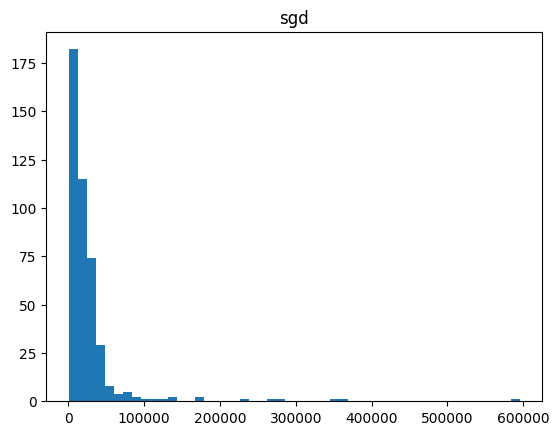

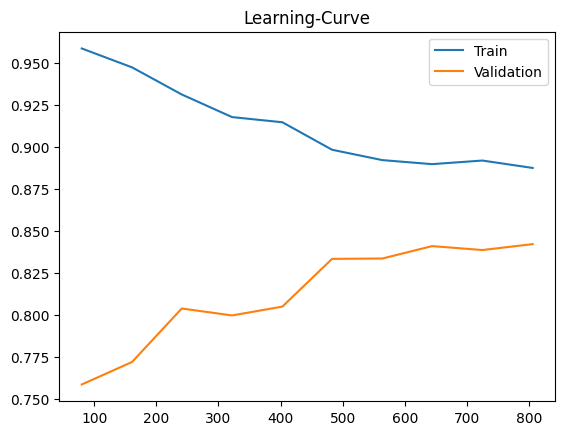

________________________________________________________________________________________________________________________
gbr
gbr {'gbr__loss': 'squared_error', 'gbr__n_estimators': 180, 'gbr__subsample': 1}
MAE----------------- : 17665.212798249937
RMSE---------------- : 31965.038935650315
Median abs err------ : 10784.505510523973
R2------------------ : 0.9843601976300379
________________________________________________________________________________________________________________________


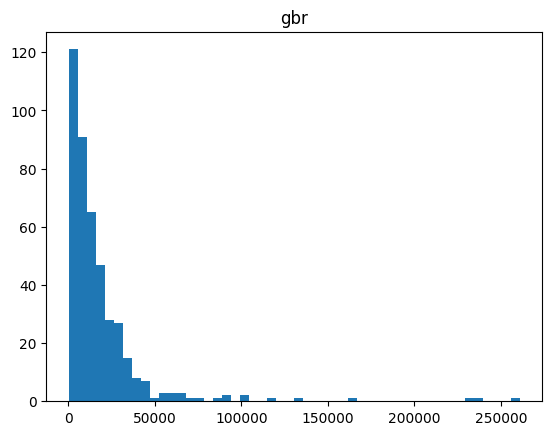

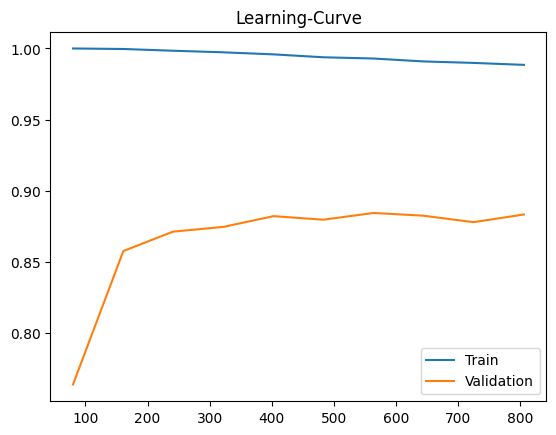

________________________________________________________________________________________________________________________
knn
knn {'knn__leaf_size': 10, 'knn__n_neighbors': 10, 'knn__p': 1}
MAE----------------- : 21194.57175925926
RMSE---------------- : 39951.5215419089
Median abs err------ : 11730.0
R2------------------ : 0.8528931948075917
________________________________________________________________________________________________________________________


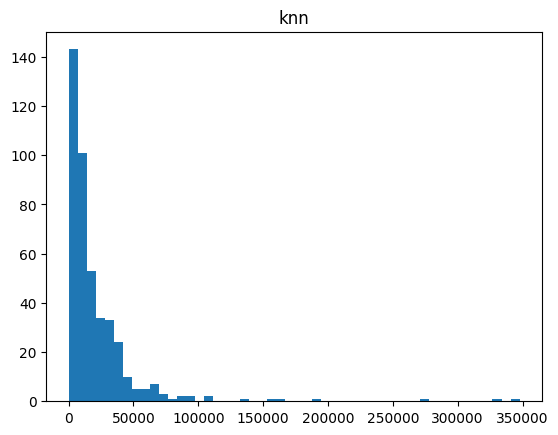

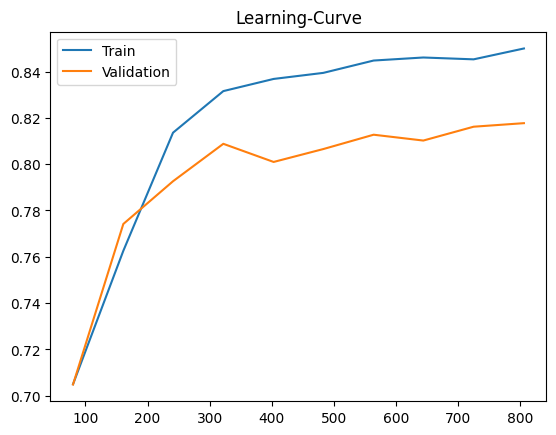

________________________________________________________________________________________________________________________
svr
svr {'svr__C': 1000, 'svr__fit_intercept': True, 'svr__tol': 0.0001}
MAE----------------- : 19842.742062924473
RMSE---------------- : 42964.1263283448
Median abs err------ : 12495.531175704935
R2------------------ : 0.8623267641881158
________________________________________________________________________________________________________________________


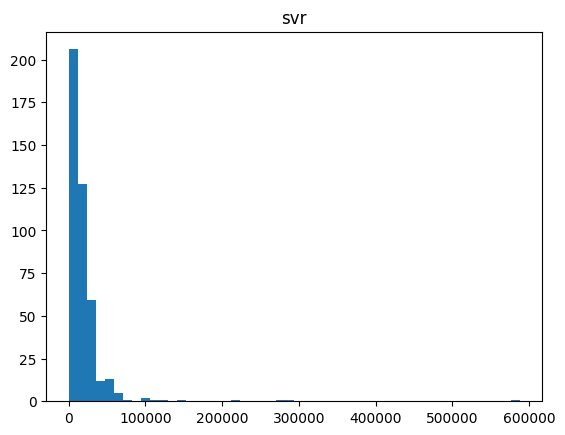

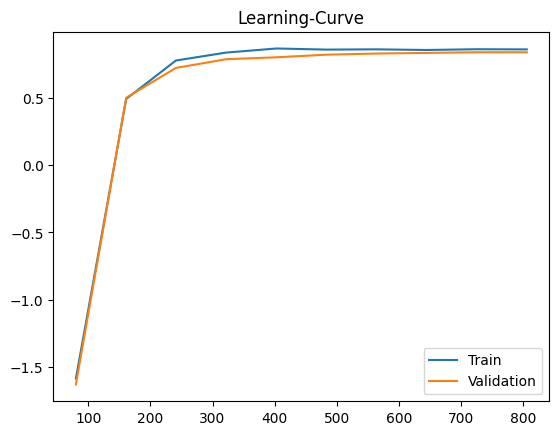

________________________________________________________________________________________________________________________
rf
rf {'rf__criterion': 'absolute_error', 'rf__max_depth': 19, 'rf__max_features': 20, 'rf__n_estimators': 45}
MAE----------------- : 17964.1524691358
RMSE---------------- : 33920.6828830753
Median abs err------ : 11187.03333333334
R2------------------ : 0.9823252598377059
________________________________________________________________________________________________________________________


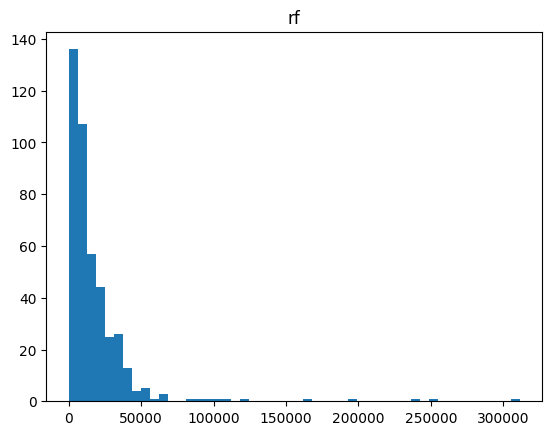

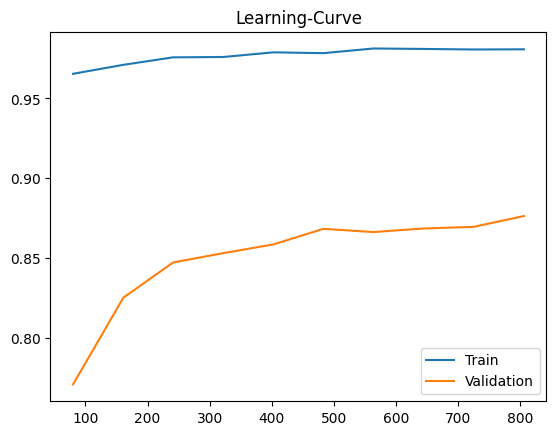

  Name           MAE          RMSE  Median abs err        R2
0  sgd  25011.235351  52706.141112    14664.645650  0.884565
1  gbr  17665.212798  31965.038936    10784.505511  0.984360
2  knn  21194.571759  39951.521542    11730.000000  0.852893
3  svr  19842.742063  42964.126328    12495.531176  0.862327
4   rf  17964.152469  33920.682883    11187.033333  0.982325


In [25]:
train_function(X1, y1, preprocessor_numerobis)

En modifiant , la base de donnée :  créations des colonnes 'haspool','has2ndfloor','hasgarage','hasbsmt' et 'hasfireplace', en suppriment les ventes faites entre membres d'une famille et en changeant la façon d'encoder nos données. Nous avons les résultats suivants.  

De manière générale, les médians et les scores R2 sont meilleurs que vu plutot. Cependant, les scores MAE et RMSE sont eux moins bons : nous pouvons supposer que nous avons accentué l'importance des outliers, mais que dans la généralité, nos modèles sont plus précis.  

Parlons maintenant de SVR, tout à l'heure nous n'arrivions pas à tirer des conlusions de ce modèle, en changeant ses paramètres, il s'en sort bien mieux. Avec un MAE de 19842 et un RMSE de 42964, il a des scores très proches de ceux de SGD et lasso de tout à l'heure.
